In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from tensorflow.keras.applications import EfficientNetB0
from keras import backend as K
from sklearn.model_selection import train_test_split

In [33]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
X = []
y = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/kaggle/input/brain-tumor-classification-mri','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        img = tf.cast(img, tf.float32)
        X.append(img)
        y.append(i)
for i in labels:
    folderPath = os.path.join('/kaggle/input/brain-tumor-classification-mri','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        img = tf.cast(img, tf.float32)
        X.append(img)
        y.append(i)
        
X = np.array(X_train)
y = np.array(y_train)

y_new = []
for i in y:
    y_new.append(labels.index(i))
y = y_new
y = tf.keras.utils.to_categorical(y)

X.shape, y.shape

100%|██████████| 74/74 [00:00<00:00, 128.65it/s]


((2088, 150, 150, 3), (2088, 4))

Text(0.5, 1.0, 'meningioma_tumor')

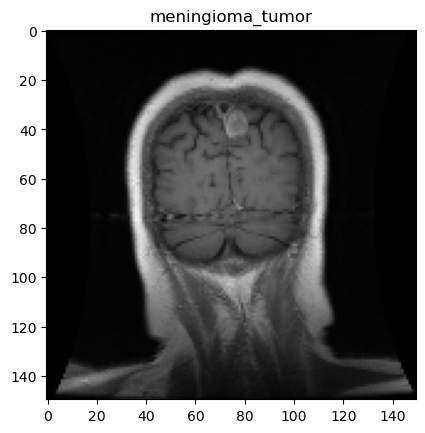

In [27]:
plt.imshow(X_train[1])
plt.title(y_train[1])

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_train.shape, X_test.shape

((1670, 150, 150, 3), (418, 150, 150, 3))

In [35]:
y_train

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [38]:
X_train = (X_train - np.mean(X_train))/(np.max(X_train))

In [39]:
class AssymetricLossNeuralNetwork():
    """
    This class abstract as simple nueral network with an assymetric loss. The parameter k is the multiplier for a class that needs to be prioritized.
    """
    def __init__(
            self,
            k: tuple,
            image_size: tuple,
            batch_size: int,
            ) -> None:
        self.k = k
        self.batch_size = batch_size
        self.image_size = image_size
        self.epsilon = 1e7

    def loss(self, y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * np.array([10, 1, 1, 1])
        loss = -K.sum(loss, -1)
        return loss

    def fit(self, learning_rate: float, epochs: int, X_train, y_train):

        model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(4, activation='softmax')
        ])
        model.compile(loss=self.loss, optimizer = 'Adam', metrics = ['accuracy'])
        history = model.fit(X_train,y_train,validation_split=0.1, epochs = epochs, batch_size=self.batch_size)

        return model

In [61]:
image_size = (150, 150)
batch_size = 32
asylnn = AssymetricLossNeuralNetwork(k = (10.0, 1.0, 1.0, 1.0), image_size = image_size, batch_size = batch_size)
model = asylnn.fit(0.001, 15, X_train, y_train)

Epoch 1/15
47/47 [==============================] - 3s 23ms/step - loss: 2.2696 - accuracy: 0.3540 - val_loss: 1.8167 - val_accuracy: 0.5868
Epoch 2/15
47/47 [==============================] - 1s 17ms/step - loss: 1.4579 - accuracy: 0.5642 - val_loss: 1.2886 - val_accuracy: 0.5928
Epoch 3/15
47/47 [==============================] - 1s 18ms/step - loss: 0.9350 - accuracy: 0.7199 - val_loss: 1.9733 - val_accuracy: 0.7305
Epoch 4/15
47/47 [==============================] - 1s 17ms/step - loss: 0.6639 - accuracy: 0.8283 - val_loss: 1.3954 - val_accuracy: 0.7784
Epoch 5/15
47/47 [==============================] - 1s 17ms/step - loss: 0.4491 - accuracy: 0.8703 - val_loss: 1.3835 - val_accuracy: 0.7904
Epoch 6/15
47/47 [==============================] - 1s 19ms/step - loss: 0.3682 - accuracy: 0.9029 - val_loss: 1.7839 - val_accuracy: 0.7605
Epoch 7/15
47/47 [==============================] - 1s 17ms/step - loss: 0.3315 - accuracy: 0.9242 - val_loss: 1.8132 - val_accuracy: 0.7844
Epoch 8/15
47

In [63]:
from sklearn.metrics import classification_report, confusion_matrix

X_test_processed = (X_test - np.mean(X_test))/(np.max(X_test))

pred = model.predict(X_test_processed)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

print(classification_report(y_test_new,pred))

13/13 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.79      0.71      0.75       100
           1       0.85      0.77      0.81       115
           2       0.79      0.89      0.84       105
           3       0.85      0.96      0.90        74

    accuracy                           0.82       394
   macro avg       0.82      0.83      0.82       394
weighted avg       0.82      0.82      0.82       394



In [64]:
model.evaluate(X_test_processed, y_test)

13/13 [==============================] - 0s 11ms/step - loss: 6.4962 - accuracy: 0.8198


[6.496222496032715, 0.8197969794273376]

In [66]:
glioma_test = y_test_new == 0
np.mean(pred[glioma_test] == y_test_new[glioma_test])

0.71